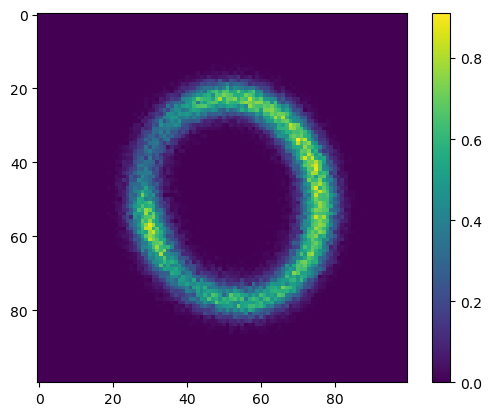

In [10]:
from catalog_manager import CatalogManager
import json
from lensing_system import LensingSystem
from shared_utils import recursive_to_tensor, _grid_lens
from matplotlib import pyplot as plt
from noise_applicator import NoiseApplicator, GaussKernel

device = "cuda"

grid = _grid_lens(6, 100, device=device)

my_catalog = CatalogManager(catalog_name_input="first_bad_testing_catalog.json")
one_image_dict = my_catalog.catalog["SL_systems"][10]
one_image_dict = recursive_to_tensor(one_image_dict, device=device)
#print(json.dumps(one_image_dict, indent=4))
lensing_system = LensingSystem(one_image_dict, device=device)
image = lensing_system(grid)

# Create a Gaussian kernel
gauss_kernel = GaussKernel(kernel_size=10, sigma=2, device=device).get_kernel()
sky_level = 0.00
psf_and_poisson = NoiseApplicator(
    psf=gauss_kernel, 
    apply_poisson=True, 
    gain=100,
    sky_level=sky_level,
    device=device
)


image = image.float()
image = image.unsqueeze(0).unsqueeze(0)  # Add batch and channel dims

noisy_image = psf_and_poisson.apply(image)
noisy_image_for_plot = noisy_image.squeeze().cpu().detach().numpy()
noisy_image_for_plot = noisy_image_for_plot.clip(0, 1)

plt.imshow(noisy_image_for_plot)
plt.colorbar()
plt.show()
